In [2]:
import pandas as pd
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import warnings
warnings.simplefilter(action='ignore')

In [3]:
with zipfile.ZipFile("credit-risk-dataset.zip") as myzip:
    data = myzip.open("loan/loan.csv")

df = pd.read_csv(data)
df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,1077501,1296599,5000.0,5000.0,4975.0,36 months,10.65,162.87,B,B2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1077430,1314167,2500.0,2500.0,2500.0,60 months,15.27,59.83,C,C4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1077175,1313524,2400.0,2400.0,2400.0,36 months,15.96,84.33,C,C5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1076863,1277178,10000.0,10000.0,10000.0,36 months,13.49,339.31,C,C1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1075358,1311748,3000.0,3000.0,3000.0,60 months,12.69,67.79,B,B5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df.isnull().sum()

id                       0
member_id                0
loan_amnt                0
funded_amnt              0
funded_amnt_inv          0
                     ...  
all_util            866007
total_rev_hi_lim     70276
inq_fi              866007
total_cu_tl         866007
inq_last_12m        866007
Length: 74, dtype: int64

In [5]:
df_sample = df.sample(frac=0.15)
df_sample.info()

<class 'pandas.core.frame.DataFrame'>
Index: 133107 entries, 375211 to 51611
Data columns (total 74 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           133107 non-null  int64  
 1   member_id                    133107 non-null  int64  
 2   loan_amnt                    133107 non-null  float64
 3   funded_amnt                  133107 non-null  float64
 4   funded_amnt_inv              133107 non-null  float64
 5   term                         133107 non-null  object 
 6   int_rate                     133107 non-null  float64
 7   installment                  133107 non-null  float64
 8   grade                        133107 non-null  object 
 9   sub_grade                    133107 non-null  object 
 10  emp_title                    125333 non-null  object 
 11  emp_length                   126346 non-null  object 
 12  home_ownership               133107 non-null  object 
 13  

In [6]:
df_sample.columns

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title',
       'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
       'issue_d', 'loan_status', 'pymnt_plan', 'url', 'desc', 'purpose',
       'title', 'zip_code', 'addr_state', 'dti', 'delinq_2yrs',
       'earliest_cr_line', 'inq_last_6mths', 'mths_since_last_delinq',
       'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'initial_list_status', 'out_prncp',
       'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp',
       'total_rec_int', 'total_rec_late_fee', 'recoveries',
       'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt',
       'next_pymnt_d', 'last_credit_pull_d', 'collections_12_mths_ex_med',
       'mths_since_last_major_derog', 'policy_code', 'application_type',
       'annual_inc_joint', 'dti_joint', 'verification_status_joint',
    

In [7]:
columns = ['loan_amnt', 'int_rate', 'term', 'dti', 'annual_inc', 'delinq_2yrs', 'open_acc',
           'grade', 'home_ownership', 'collections_12_mths_ex_med', 'revol_bal', 'total_acc',
           'loan_status']

df_clean = df_sample[columns]
df_clean.head()

,loan_amnt,int_rate,term,dti,annual_inc,delinq_2yrs,open_acc,grade,home_ownership,collections_12_mths_ex_med,revol_bal,total_acc,loan_status
375211,16000.0,11.67,36 months,10.07,109000.0,0.0,9.0,B,MORTGAGE,0.0,25947.0,18.0,Current
784440,15000.0,12.69,36 months,7.75,52490.0,0.0,9.0,C,MORTGAGE,0.0,12447.0,10.0,Current
482463,13000.0,7.89,36 months,32.36,70000.0,2.0,8.0,A,OWN,0.0,1764.0,23.0,Current
838317,11325.0,16.55,36 months,3.52,100000.0,1.0,12.0,D,MORTGAGE,0.0,6794.0,16.0,Current
233551,20000.0,13.66,60 months,20.98,72000.0,1.0,12.0,C,MORTGAGE,0.0,19576.0,28.0,Current


In [8]:
df_clean.isnull().sum()

loan_amnt                      0
int_rate                       0
term                           0
dti                            0
annual_inc                     0
delinq_2yrs                    4
open_acc                       4
grade                          0
home_ownership                 0
collections_12_mths_ex_med    20
revol_bal                      0
total_acc                      4
loan_status                    0
dtype: int64

In [9]:
def categorize_loan_status(status):
    if status in ['Fully Paid', 'In Grace Period', 'Issued']:
        return 'Normal'
    elif status in ['Late (16-30 days)', 'Late (31-120 days)']:
        return 'Delinquent'
    elif status in ['Charged Off', 'Default']:
        return 'Default'
    elif 'Does not meet the credit policy' in status:
        return 'Not Compliant'
    elif 'Current' in status:
        return 'Current'
    else:
        return 'Unknown'
    
df_clean['loan_status'] = df_clean['loan_status'].apply(categorize_loan_status)

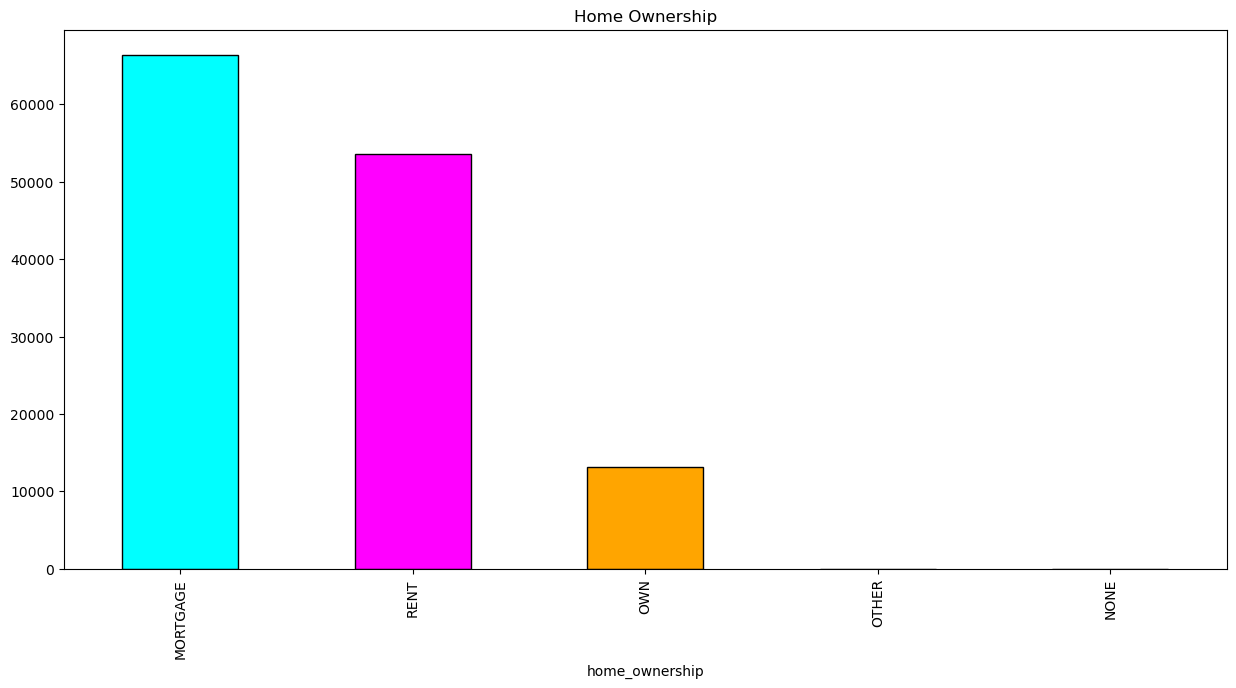

In [10]:
# Plot Count vs Home Ownership
# Label 0 = Mortgage, 1 = Misc, 2 = Other, 3 = Own, 4 = Rent
colors = ['cyan', 'magenta', 'orange', 'purple', 'red']
df_clean['home_ownership'].value_counts().plot(kind='bar', 
        title='Home Ownership', color=colors, edgecolor='black', figsize=(15,7))

plt.show()

<Axes: xlabel='int_rate', ylabel='grade'>

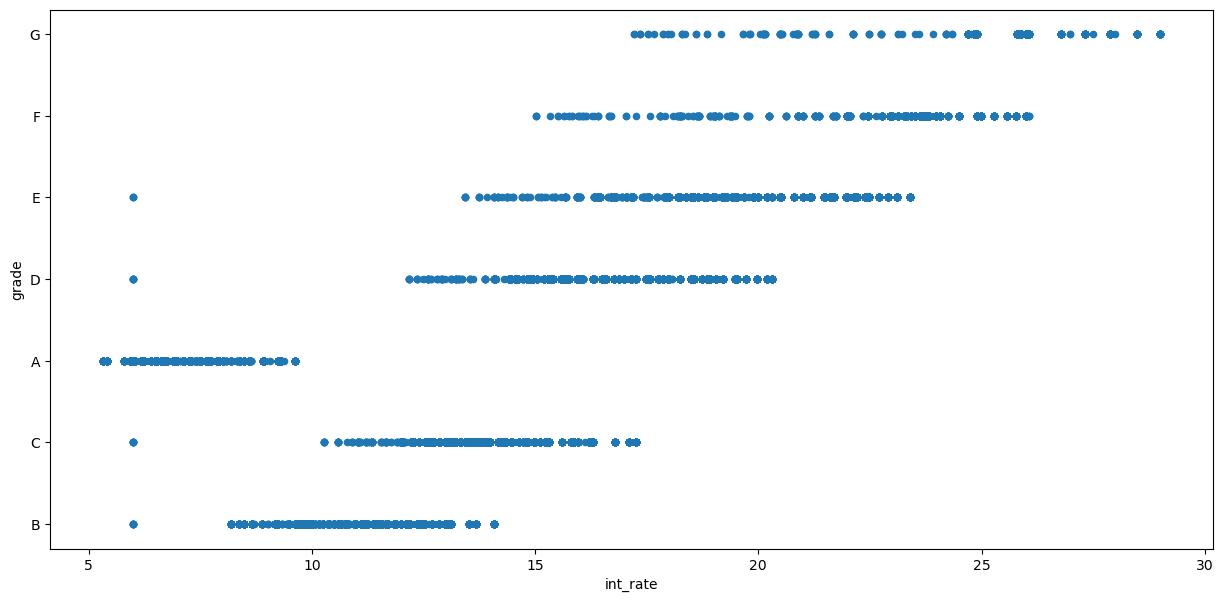

In [11]:
# Plot df_data_clean['int_rate'] vs grade
df_clean.plot.scatter(x='int_rate', y='grade', figsize=(15,7))

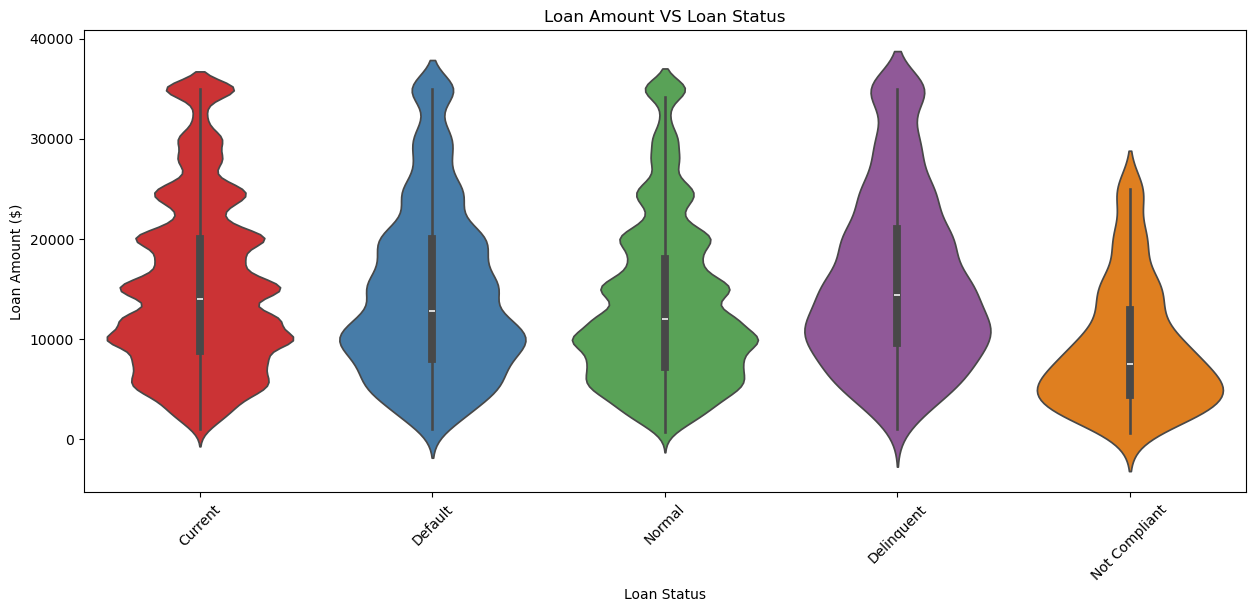

In [50]:
plt.figure(figsize=(15, 6))
sns.violinplot(x='loan_status', y='loan_amnt', palette='Set1' ,data=df_clean)
plt.title('Loan Amount VS Loan Status')
plt.xlabel('Loan Status')
plt.ylabel('Loan Amount ($)')
plt.xticks(rotation=45)
plt.show()

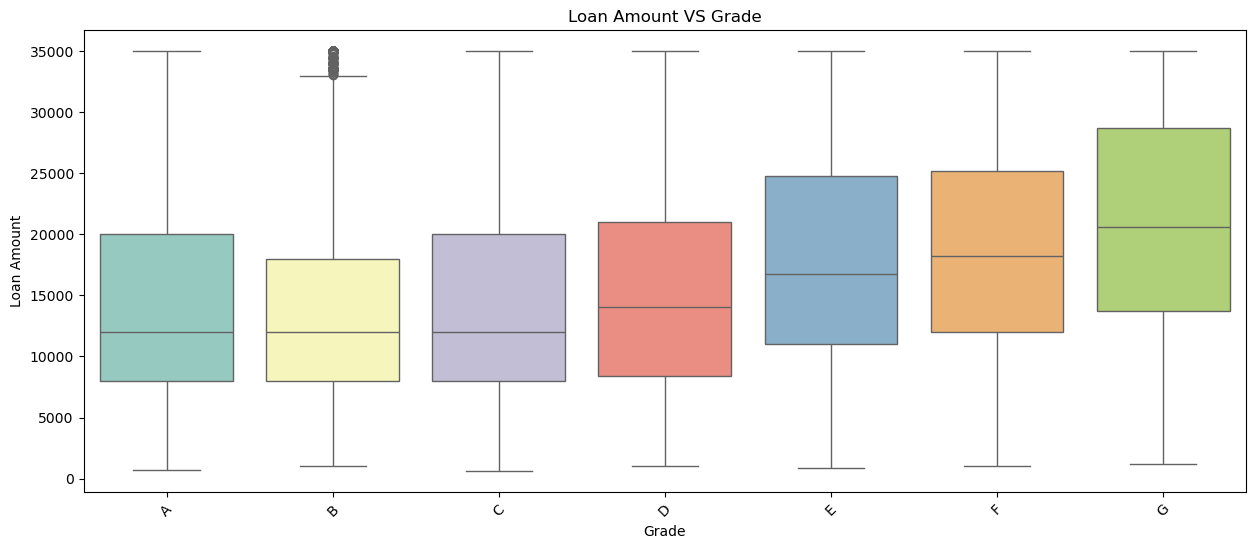

In [51]:
order_grade  = ['A', 'B', 'C', 'D', 'E', 'F', 'G']

plt.figure(figsize=(15, 6))
sns.boxplot(x='grade', y='loan_amnt', data=df_clean, palette='Set3', order=order_grade)
plt.title('Loan Amount VS Grade')
plt.xlabel('Grade')
plt.ylabel('Loan Amount')
plt.xticks(rotation=45)
plt.show()

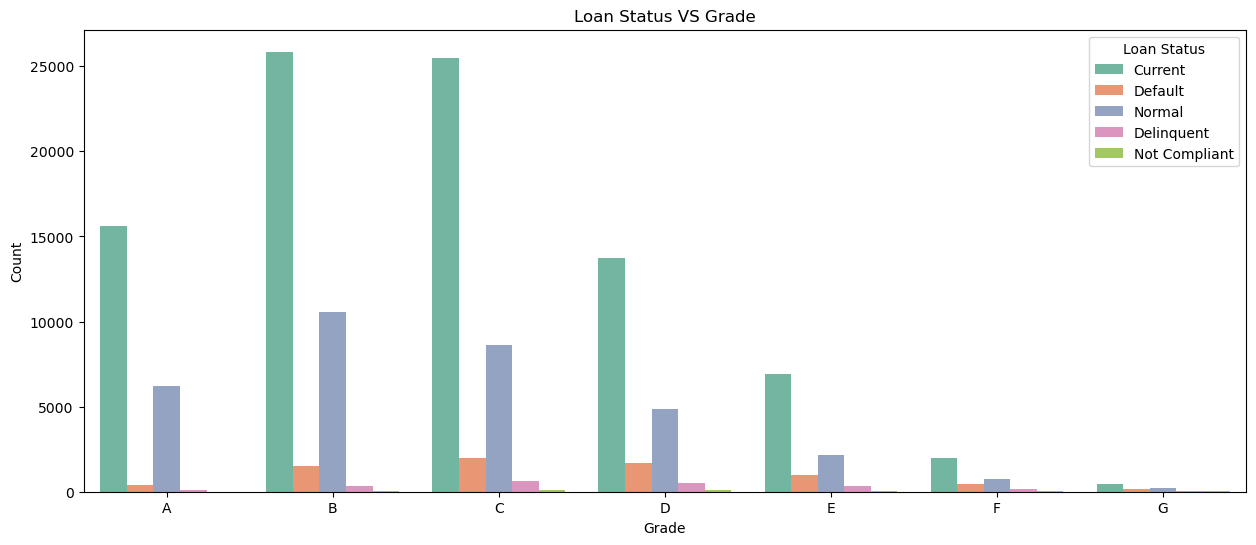

In [52]:
plt.figure(figsize=(15, 6))
sns.countplot(x='grade', hue='loan_status', data=df_clean, palette='Set2', order= order_grade)
plt.title('Loan Status VS Grade')
plt.xlabel('Grade')
plt.ylabel('Count')
plt.legend(title='Loan Status', loc='upper right')
plt.show()

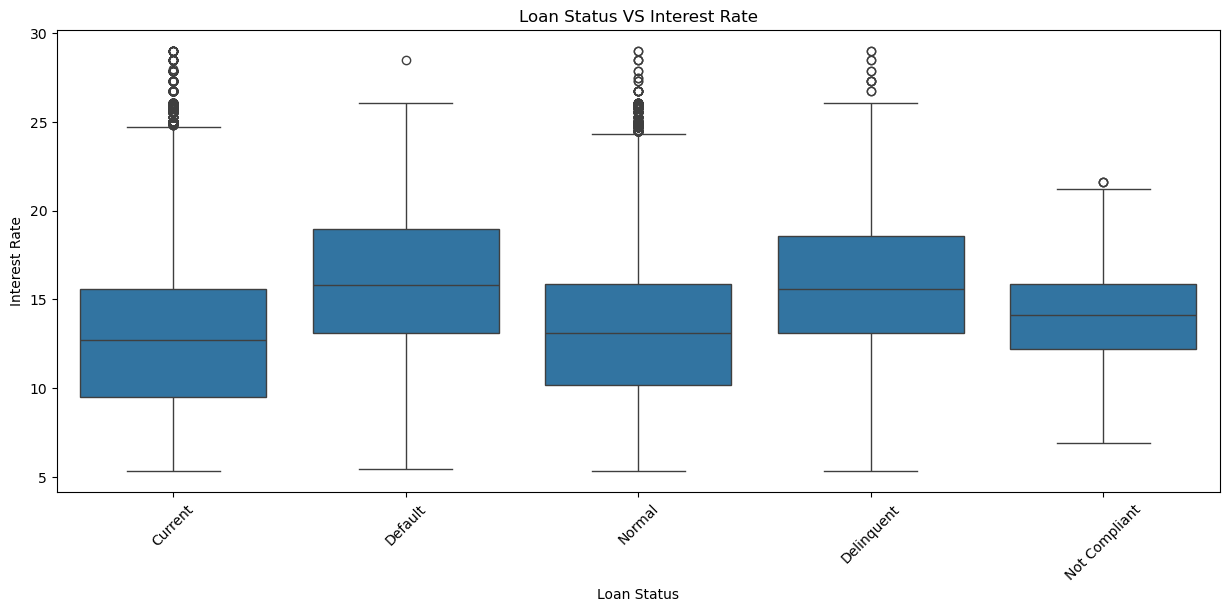

In [53]:
plt.figure(figsize=(15, 6))
sns.boxplot(x='loan_status', y = 'int_rate', data=df_clean)
plt.title('Loan Status VS Interest Rate')
plt.xlabel('Loan Status')
plt.ylabel('Interest Rate')
plt.xticks(rotation=45)
plt.show()

## *Loan Status VS Home Ownership*

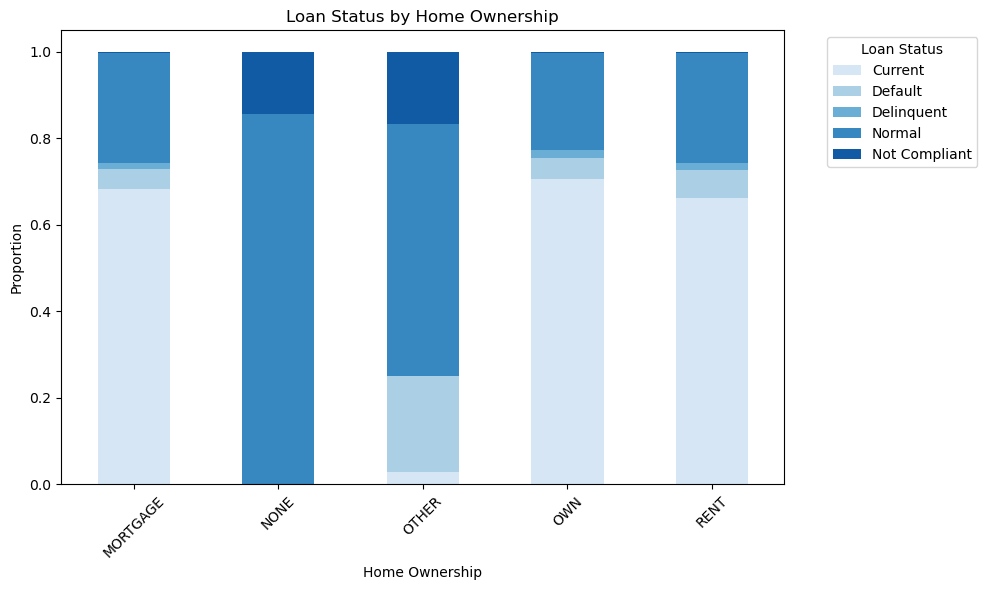

In [54]:
cross_tab = pd.crosstab(df_clean['home_ownership'], df_clean['loan_status'])

cross_tab_percentage = cross_tab.div(cross_tab.sum(1), axis=0)

colors = sns.color_palette("Blues", n_colors=cross_tab_percentage.shape[1])
cross_tab_percentage.plot(kind='bar', stacked=True, figsize=(10, 6), color=colors)

plt.title('Loan Status by Home Ownership')
plt.xlabel('Home Ownership')
plt.ylabel('Proportion')
plt.legend(title='Loan Status', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## *Converting Categorical Data in to Numerical Data (Multi-Class Classification)*

In [55]:
from sklearn.preprocessing import LabelEncoder

def LabelEncoder1(text):
    if text == 'A':
        return 1
    elif text == 'B':
        return 2
    elif text == 'C':
        return 3
    elif text == 'D':
        return 4
    elif text == 'E':
        return 5
    elif text == 'F':
        return 6
    elif text == 'G':
        return 7

def LabelEncoder2(text):
    if text == ' 36 months':
        return 1
    else:
        return 2
    
def LabelEncoder3(text):
    if text == "RENT":
        return 1
    elif text == "MORTGAGE":
        return 2
    elif text == "OWN":
        return 3
    else:
        return 0
    
df_clean['grade'] = df_clean['grade'].apply(LabelEncoder1)
df_clean['term'] = df_clean['term'].apply(LabelEncoder2)
df_clean['home_ownership'] = df_clean['home_ownership'].apply(LabelEncoder3)



In [56]:
df_clean[['grade', 'term', 'home_ownership']].head()

,grade,term,home_ownership
462527,1,1,1
339016,2,1,2
329226,2,1,3
375605,1,1,2
71516,4,1,2


In [57]:
df_clean['loan_status'].value_counts().reset_index()

,loan_status,count
0,Current,90091
1,Normal,33371
2,Default,7139
3,Delinquent,2127
4,Not Compliant,379


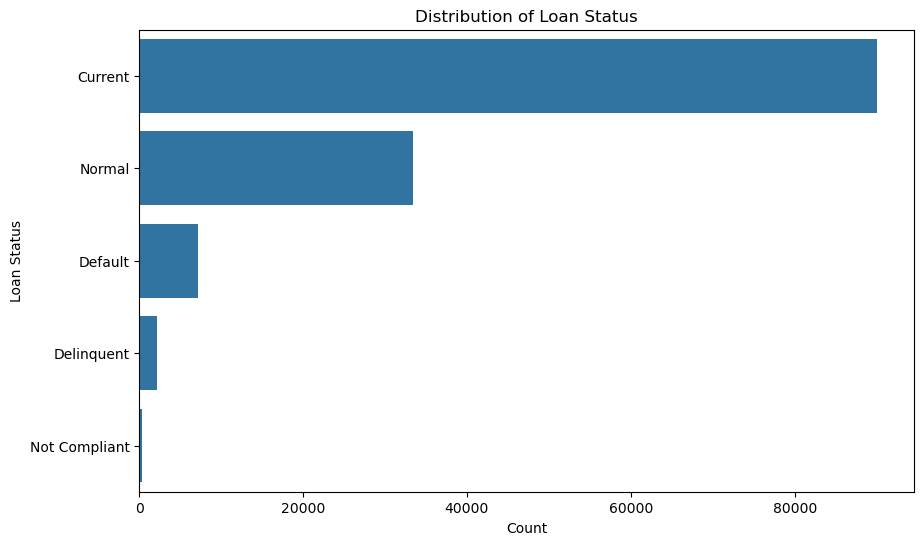

In [58]:
loan_status_counts = df_clean['loan_status'].value_counts().reset_index()
loan_status_counts.columns = ['Loan Status', 'Count']

plt.figure(figsize=(10, 6))
sns.barplot(y='Loan Status', x='Count', data=loan_status_counts)

plt.title('Distribution of Loan Status')
plt.ylabel('Loan Status')
plt.xlabel('Count')

plt.show()

Encoding Y to numeric values

In [59]:
y = df_clean['loan_status']

def y_encoded(text):
    if text == "Normal":
        return 0
    elif text in ['Default', 'Delinquent', 'Not Compliant']:
        return 1
    else:
        return 2
    
y_encode =  y.apply(y_encoded)

In [60]:
y_encode.value_counts().reset_index()

,loan_status,count
0,2,90091
1,0,33371
2,1,9645


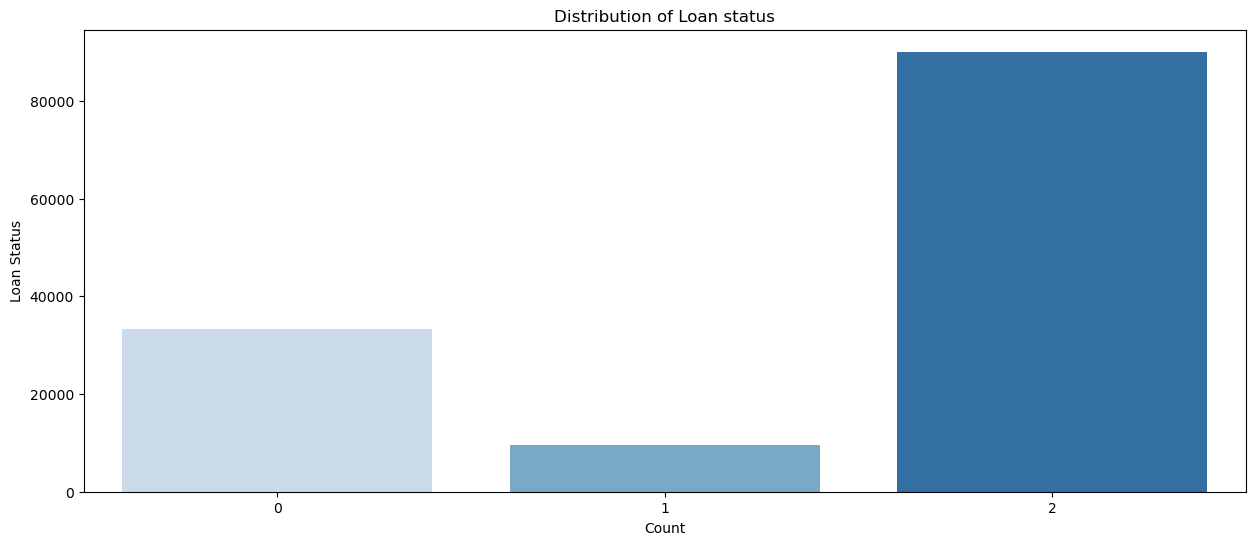

In [61]:
loan_status_counts = y_encode.value_counts().reset_index()
loan_status_counts.columns = ['Loan Status', 'Count']

plt.figure(figsize=(15, 6))
sns.barplot(y='Count', x='Loan Status', data=loan_status_counts, palette="Blues")

plt.title("Distribution of Loan status")
plt.xlabel('Count')
plt.ylabel('Loan Status')

plt.show()

Removing "Current" from Loan Status since this is not relavent to the model

In [62]:
df_clean = df_clean[df_clean['loan_status'] != 'Current']

In [63]:
df_clean['loan_status'].unique()

array(['Default', 'Normal', 'Delinquent', 'Not Compliant'], dtype=object)

In [64]:
df_clean.to_csv('loan_clean.csv', index=False)

In [65]:

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

X = df_clean.drop('loan_status', axis=1)
y = df_clean['loan_status']

y_encoded = y.map({'Normal': 0, 'Delinquent':1, 'Default':1, 'Not Compliant': 1})

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded,random_state=42, test_size=0.2, stratify=y_encoded)

xgb_model = xgb.XGBClassifier(use_label_encoder=False, n_estimators=500, learning_rate=0.01,
                              subsample=0.8, colsample_bytree=0.8)



In [66]:
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [67]:

y_pred = xgb_model.predict(X_test)

y_prob = xgb_model.predict_proba(X_test)[:, 1]

auc_score = roc_auc_score(y_test, y_prob)

# Classification Report and Confusion Matrix
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("AUC-ROC Score:", auc_score)

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.99      0.87      6675
           1       0.58      0.07      0.12      1929

    accuracy                           0.78      8604
   macro avg       0.68      0.53      0.50      8604
weighted avg       0.74      0.78      0.71      8604

Confusion Matrix:
[[6581   94]
 [1800  129]]
AUC-ROC Score: 0.6968291191220928


To Address Class imbalances, we have add a "scale_pos_weight" parameter to the model

In [68]:
y_train.value_counts()

loan_status
0    26696
1     7716
Name: count, dtype: int64

In [69]:
pos_weight = (y_train.value_counts()[0]/ y_train.value_counts()[1])

xgb_model_imporved = xgb.XGBClassifier(use_label_encoder=False, scale_pos_weight=pos_weight, eval_metric='logloss',
                                       n_estimators=500, learning_rate=0.01, subsample=0.8, colsample_bytree=0.8)

xgb_model_imporved.fit(X_train, y_train)

y_pred = xgb_model_imporved.predict(X_test)

y_prob = xgb_model_imporved.predict_proba(X_test)[:, 1]
auc_score = roc_auc_score(y_test, y_prob)

print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("AUC-ROC Score:", auc_score)

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.64      0.74      6675
           1       0.34      0.63      0.44      1929

    accuracy                           0.64      8604
   macro avg       0.60      0.64      0.59      8604
weighted avg       0.74      0.64      0.67      8604

Confusion Matrix:
[[4291 2384]
 [ 707 1222]]
AUC-ROC Score: 0.6957311525445449


In [72]:
from imblearn.over_sampling import RandomOverSampler

oversampler = RandomOverSampler(random_state=42)
X_oversampled, y_oversampled = oversampler.fit_resample(X_train, y_train)

print("After Oversampling:", y_oversampled.value_counts())

X_train1, X_test1, y_train1, y_test1 = train_test_split(X_oversampled, y_oversampled, random_state=42)

After Oversampling: loan_status
1    26696
0    26696
Name: count, dtype: int64


In [73]:
xgb_model_oversampled = xgb_model.fit(X_train1, y_train1)

y_pred = xgb_model_oversampled.predict(X_test1)

y_prob = xgb_model_oversampled.predict_proba(X_test1)[:, 1]

auc_score = roc_auc_score(y_test1, y_prob)

print("Classification Report:")
print(classification_report(y_test1, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test1, y_pred))
print("AUC-ROC Score:", auc_score)

Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.65      0.67      6720
           1       0.67      0.71      0.69      6628

    accuracy                           0.68     13348
   macro avg       0.68      0.68      0.68     13348
weighted avg       0.68      0.68      0.68     13348

Confusion Matrix:
[[4372 2348]
 [1928 4700]]
AUC-ROC Score: 0.743895127453516


In [81]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, make_scorer

xgb_model_imporved = xgb.XGBClassifier(scale_pos_weight=pos_weight, eval_metric='logloss')

param_grid ={
    'max_depth':[3, 5, 7],
    'learning_rate':[0.1, 0.01, 0.001],
    'subsample':[0.5, 0.7, 1]
}

scorer = make_scorer(roc_auc_score, needs_proba=True)
grid_search = GridSearchCV(xgb_model_imporved, param_grid, cv=5, scoring=scorer)

grid_search.fit(X_train1, y_train1)

print("Best set of hyperparameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Best set of hyperparameters:  {'learning_rate': 0.1, 'max_depth': 7, 'subsample': 0.7}
Best score:  0.7942770139407168


In [82]:
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as stats
from sklearn.metrics import roc_auc_score, make_scorer

param_dist = {
    'max_depth':stats.randint(3,10),
    'learning_rate':stats.uniform(0.01, 0.1),
    'subsample':stats.uniform(0.5, 0.5),
    'n_estimators':stats.randint(50, 200)
}

xgb_model_imporved = xgb.XGBClassifier(scale_pos_weight=pos_weight, eval_metric='logloss')

scorer = make_scorer(roc_auc_score, needs_proba=True)
random_search = RandomizedSearchCV(xgb_model_imporved, param_distributions=param_dist, n_iter=10, cv=5, scoring=scorer)

random_search.fit(X_train1, y_train1)

print("Best set of hyperparameters: ", random_search.best_params_)
print("Best score: ", random_search.best_score_)

Best set of hyperparameters:  {'learning_rate': 0.10416280101980746, 'max_depth': 8, 'n_estimators': 71, 'subsample': 0.7202218342375274}
Best score:  0.8094205065780219


Trying Random Under Sampling to see if the model can be improved

In [74]:
from imblearn.under_sampling import RandomUnderSampler

undersampler = RandomUnderSampler(random_state=42)
X_undersampled, y_undersampled = undersampler.fit_resample(X_train, y_train)

print("After Undersampling:", y_undersampled.value_counts())

X_train2, X_test2, y_train2, y_test2 = train_test_split(X_undersampled, y_undersampled, random_state=42)

After Undersampling: loan_status
0    7716
1    7716
Name: count, dtype: int64


In [75]:
xgb_model_undersampled = xgb_model.fit(X_train2, y_train2)

y_pred = xgb_model_undersampled.predict(X_test2)

y_prob = xgb_model_undersampled.predict_proba(X_test2)[:, 1]

auc_score = roc_auc_score(y_test2, y_prob)

print("Classification Report:")
print(classification_report(y_test2, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test2, y_pred))
print("AUC-ROC Score:", auc_score)

Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.62      0.64      1942
           1       0.64      0.68      0.66      1916

    accuracy                           0.65      3858
   macro avg       0.65      0.65      0.65      3858
weighted avg       0.65      0.65      0.65      3858

Confusion Matrix:
[[1209  733]
 [ 622 1294]]
AUC-ROC Score: 0.6973458103369318


Using RandomForestClassifier to check Accuracy of XGBoost model

In [83]:
# Train the Random Forest model to compare with K-Nearest Neighbor model
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=1, n_estimators=71).fit(X_train, y_train)

# Evaluate the model
print(f'Training Score by RF: {rf.score(X_train, y_train)}')
print(f'Testing Score by RF: {rf.score(X_test, y_test)}')

Training Score by RF: 0.9998547018481925
Testing Score by RF: 0.7762668526266853


In [85]:
# Make predictions using the testing data
predictions = rf.predict(X_test)

# Calculate the accuracy score
from sklearn.metrics import accuracy_score
y_prob = rf.predict_proba(X_test)[:, 1]

auc_score = roc_auc_score(y_test, y_prob)
# Display the accuracy score
print("AUC-ROC Score:", auc_score)

AUC-ROC Score: 0.6751143108439489


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, recall_score, f1_score

models = [
    ('Randam Forest', RandomForestClassifier(random_state=42)),
    ('Decision Tress', DecisionTreeClassifier(random_state=42))
]

for model_name, model in models:
    print(f"Training and evaluating {model_name}")

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prod = model.predict_proba(X_test)

    recall = recall_score(y_test, y_pred, pos_label=1)
    f1 = f1_score(y_test, y_pred, pos_label=1)
    auc_score = roc_auc_score(y_test, y_prob)

    print(f"{model_name} - Recall: {recall:.4f}, F1-score: {f1:.4f},auc_score: {auc_score:.4f}")
    print(classification_report(y_test, y_pred, target_names=['Normal', 'Default']))
    print("-" * 50)

Training and evaluating Randam Forest
Randam Forest - Recall: 0.0781, F1-score: 0.1332,auc_score: 0.6971
              precision    recall  f1-score   support

      Normal       0.79      0.97      0.87      6714
     Default       0.45      0.08      0.13      1896

    accuracy                           0.78      8610
   macro avg       0.62      0.53      0.50      8610
weighted avg       0.72      0.78      0.71      8610

--------------------------------------------------
Training and evaluating Decision Tress
Decision Tress - Recall: 0.3059, F1-score: 0.2920,auc_score: 0.6971
              precision    recall  f1-score   support

      Normal       0.80      0.78      0.79      6714
     Default       0.28      0.31      0.29      1896

    accuracy                           0.67      8610
   macro avg       0.54      0.54      0.54      8610
weighted avg       0.68      0.67      0.68      8610

--------------------------------------------------
Training and evaluating Logistic

ValueError: Input X contains NaN.
LogisticRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values